# Pet-проект по анализу популярных профессий и предсказанию их заработной платы

In [1]:
#Библиотека для работы с данными
import pandas as pd
import numpy as np

#Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import country_converter as coco
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
from IPython.display import Image

#Библиотеки для машинного обучения
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor

In [2]:
display(Image(url='https://i2.wp.com/miro.medium.com/0*XnXjAgoowZVCmDO4.png', 
              width = 1920) 
       )

In [3]:
df = pd.read_csv('ds_salaries.csv')
df = df.drop('Unnamed: 0',axis=1)

### 1. **Обработка пропущенных элементов**

In [4]:
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [5]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


### 2. **EDA анализ**

### 2.1 График, показывающий динамику выбора профессий в течение 3 лет

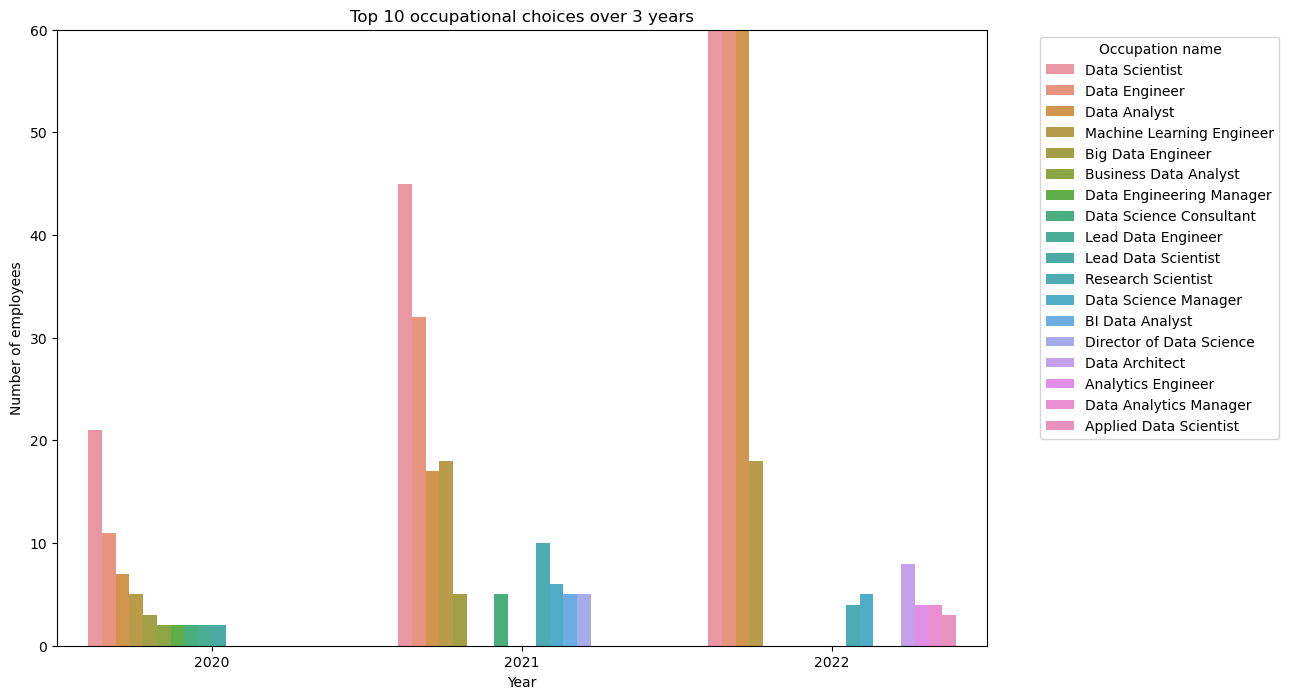

In [6]:
top10_by_year = df.groupby(['work_year', 'job_title']).size().groupby('work_year').nlargest(10).reset_index(level=0, drop=True).reset_index(name='count')

plt.figure(figsize=(12, 8))

sns.barplot(x='work_year', y='count', hue='job_title', data=top10_by_year, dodge=True)

plt.ylim(0,60)
plt.title('Top 10 occupational choices over 3 years')
plt.xlabel('Year')
plt.ylabel('Number of employees')
plt.legend(title='Occupation name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [7]:
professions_by_year = top10_by_year.groupby('work_year')['job_title'].apply(set)

common_professions = set.intersection(*professions_by_year)

print(common_professions)

{'Data Engineer', 'Machine Learning Engineer', 'Data Scientist', 'Data Analyst'}


**По итогу можно сказать, что такие профессии как *Machine Learning Engineer*, *Data Analyst*, *Data Scientist*, *Data Engineer* остаются самыми популярными в течение 3 лет**

In [8]:
popular_jobs_all_time = df[df['job_title'].isin(common_professions)]
popular_jobs_all_time = popular_jobs_all_time.groupby(['work_year','job_title'])['salary_in_usd'].mean().reset_index()

### 2. 2 График, показывающий изменение заработной платы в течение 3 лет

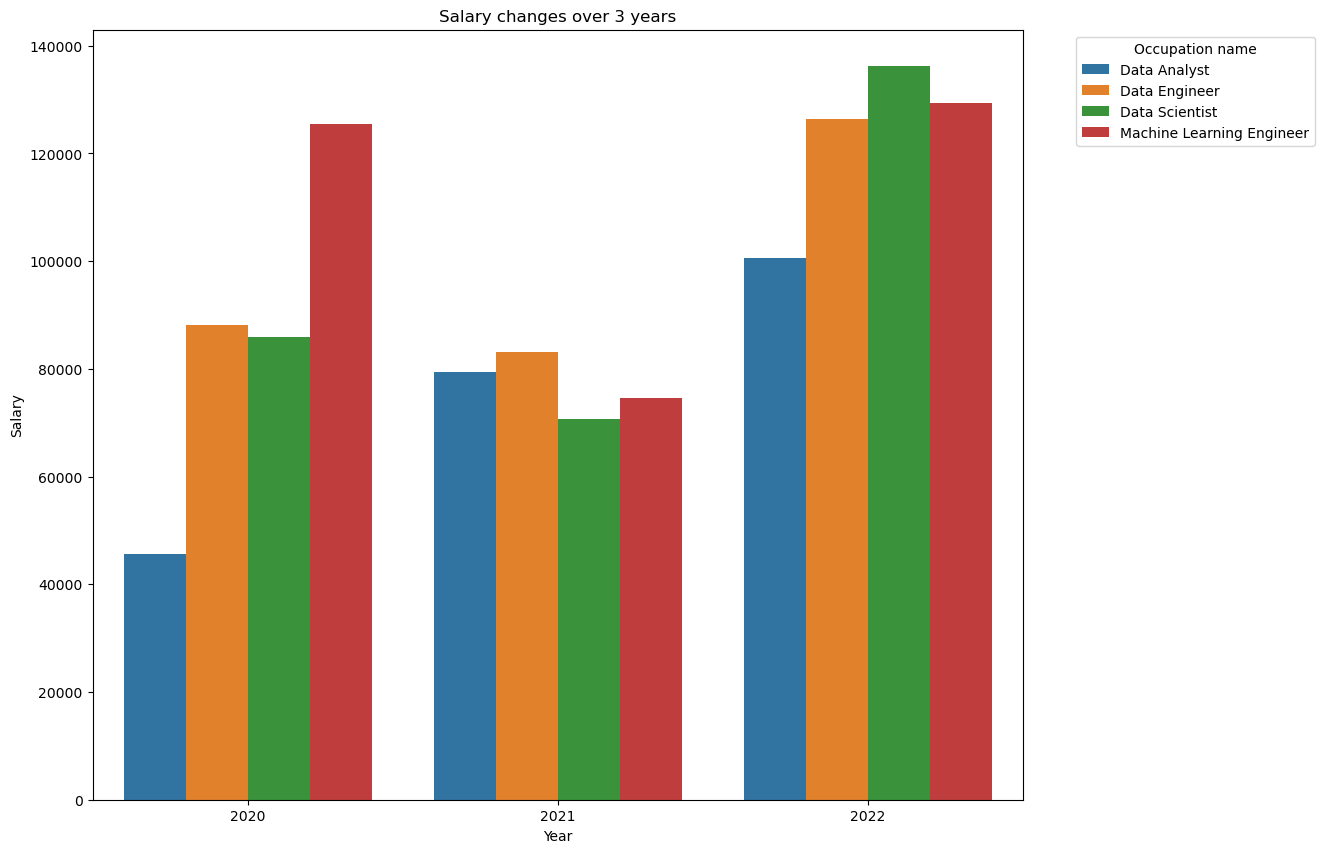

In [9]:
plt.figure(figsize=(12, 10))

sns.barplot(x='work_year', y='salary_in_usd', hue='job_title', data=popular_jobs_all_time, dodge=True)

plt.title('Salary changes over 3 years')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.legend(title='Occupation name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

**Мы можем наблюдать постоянный рост зарплаты *Data Analyst*, в том время как профессии *Data Engineer*, *Data Scientist*, *Machine Learning Engineer* имеют падание в 2021 года. По итогу в 2022 году профессии имеют рост зарплаты по сравнению с предыдущим годом**

In [10]:
df_with_growth = popular_jobs_all_time.sort_values(by=['work_year', 'job_title'])

# Добавляем столбец 'salary_growth', который содержит процентное изменение зарплаты
df_with_growth['salary_growth'] = df_with_growth.groupby('job_title')['salary_in_usd'].apply(lambda x: x.pct_change() * 100)
df_with_growth = df_with_growth.fillna(0)

/var/folders/sz/smdcg2pn0qb9qjfrp7kzvg300000gn/T/ipykernel_17172/1347436061.py:4: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



### 2.3 График, показывающий рост зарплат в процентах (по сравнению с предыдущим годом)

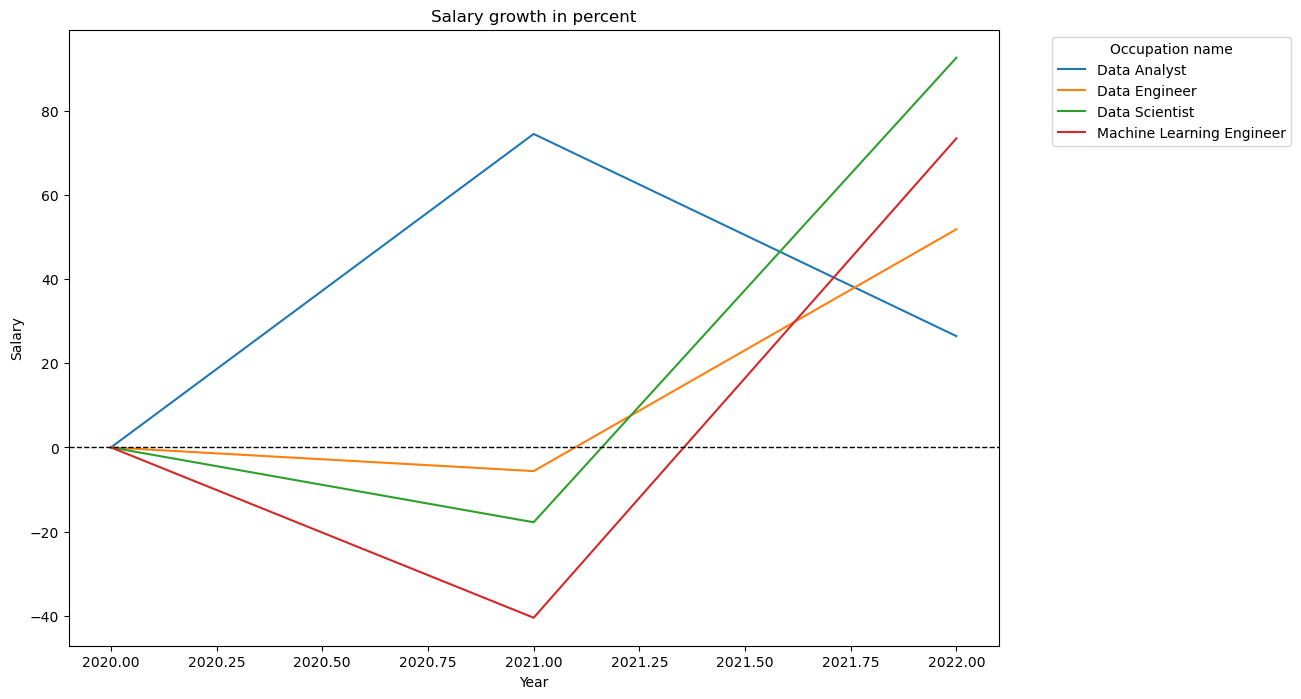

In [11]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='work_year', y='salary_growth', hue='job_title', data=df_with_growth)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.title('Salary growth in percent')
plt.xlabel('Year')
plt.ylabel('Salary')
plt.legend(title='Occupation name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [12]:
data_popular = df[df['job_title'].isin(common_professions)]
county = data_popular['company_location'].value_counts()[:10].reset_index()

In [13]:
exp_level = data_popular.groupby(['job_title', 'experience_level']).size().reset_index(name='count')


### 2.4 График, показывающий распределение уровней разработчиков в профессиях

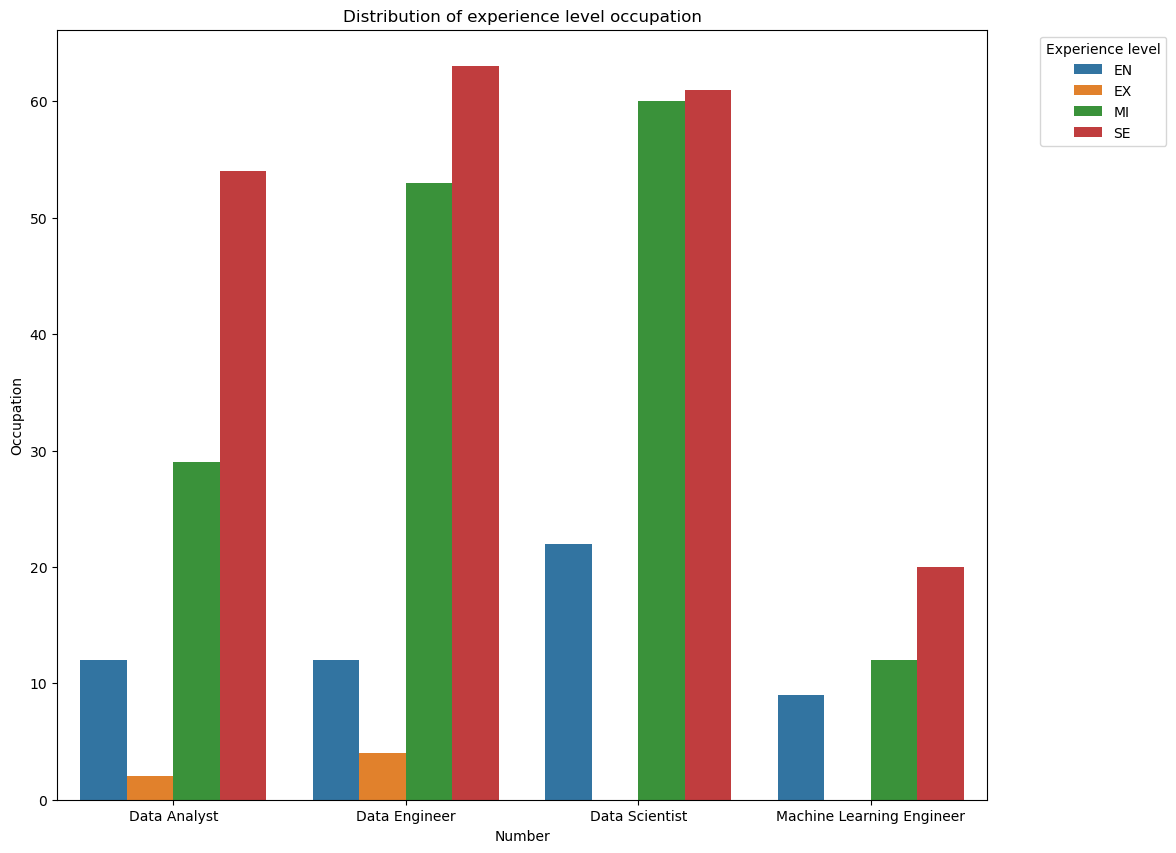

In [14]:
plt.figure(figsize=(12, 10))

sns.barplot(x='job_title', y='count', hue='experience_level', data=exp_level, dodge=True)

plt.title('Distribution of experience level occupation')
plt.xlabel('Number')
plt.ylabel('Occupation')
plt.legend(title='Experience level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [15]:
county = data_popular['company_location'].value_counts()[:10].reset_index()

### 2.5 График, показывающий топ 10 стран, предлагающих этих профессии 

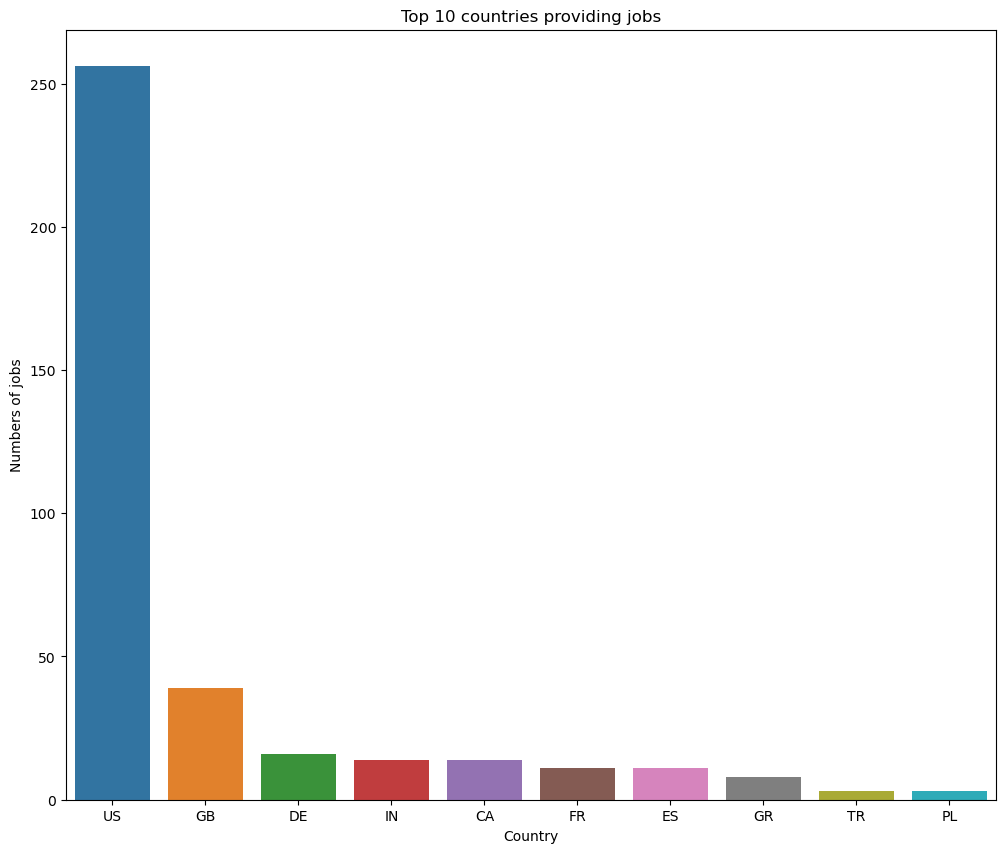

In [16]:
plt.figure(figsize=(12, 10))

sns.barplot(x='index', y='company_location', data=county, dodge=True)

plt.title('Top 10 countries providing jobs')
plt.xlabel('Country')
plt.ylabel('Numbers of jobs')

plt.show()

**Топ 10 стран *США*, *Великобритания*, *Германия*, *Индия*, *Канада*, *Франция*, *Испания*, *Греция*, *Турция*, *Польша***

### 2.6 График, показывающий расположение компаний в мире

In [17]:
converted_country = coco.convert(names=df['company_location'], to="ISO3")
df['company_location'] = converted_country

pyo.init_notebook_mode(connected=True)
company_locations_grouped = df['company_location'].value_counts()
fig = px.choropleth(locations=company_locations_grouped.index,
                   color=company_locations_grouped.values,
                   color_continuous_scale=px.colors.sequential.Purpor,
                   title='Location of companies in the world')
fig.show()

### 3. **Построение моделей машинного обучения**

### 3.1 Обработка данных

In [18]:
data = data_popular.drop(['work_year','salary_currency','salary','employee_residence'],axis=1)

Удалим колонки *work_year*, *salary_currency*, *salary*, *employee_residence*. Колонки *work_year* и *salary_currency* не влияют на з/п, *salary* показывает заработную плату до вычета нологов, это фича сильно коррелирует с нашим таргетом *salary_in_usd*, поэтому мы её исключим, фича *employee_residence* означает тоже самое, что и *company_location*

In [19]:
categorical_columns = data.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

Проводим OneHotEncoding категориальных колонок

In [20]:
y = df_encoded['salary_in_usd']
X = df_encoded.drop('salary_in_usd',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.2 Построение модели Linear Regression

In [21]:
pipe = Pipeline(
[('Scaler', StandardScaler()),
 ('LR', LinearRegression())])

param_grid = {
    'LR__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)


grid_search.fit(X_train, y_train)

best_model_LR = grid_search.best_estimator_

In [22]:
predictions_LR = best_model_LR.predict(X_test)

neg_mean_absolute_error_LR = mean_absolute_error(y_test, predictions_LR)
neg_mean_squared_error_LR = mean_squared_error(y_test, predictions_LR)
r2_LR = r2_score(y_test, predictions_LR)

print(f'neg_mean_absolute_error: {round(neg_mean_absolute_error_LR,2)}')
print(f'neg_mean_squared_error: {round(neg_mean_squared_error_LR,2)}')
print(f'r2: {round(r2_LR,2)}')

best_params = grid_search.best_params_

print("Лучшие параметры:", best_params)

neg_mean_absolute_error: 27396.48
neg_mean_squared_error: 1327103832.34
r2: 0.47
Лучшие параметры: {'LR__fit_intercept': True}


In [23]:
weights = best_model_LR.named_steps['LR'].coef_

weights_df = pd.DataFrame({'Feature': X_train.columns, 'Weight': weights})

weights_df['Absolute_Weight'] = weights_df['Weight'].abs()
weights_df = weights_df.sort_values(by='Absolute_Weight', ascending=False)

top_10_weights = weights_df.head(10)
print(top_10_weights)

                                Feature        Weight  Absolute_Weight
43                  company_location_US  28676.823350     28676.823350
3                   experience_level_SE  19880.084198     19880.084198
8   job_title_Machine Learning Engineer  16469.699144     16469.699144
7              job_title_Data Scientist  16445.837335     16445.837335
5                    employment_type_PT  13546.264966     13546.264966
4                    employment_type_FT  13450.921465     13450.921465
6               job_title_Data Engineer  12774.807200     12774.807200
1                   experience_level_EX   9960.557882      9960.557882
46                       company_size_S  -8130.766405      8130.766405
28                  company_location_IN  -6828.585013      6828.585013


### 3.3 График, показывающий топ 10 фичей, наиболее влияющих на построение модели LR

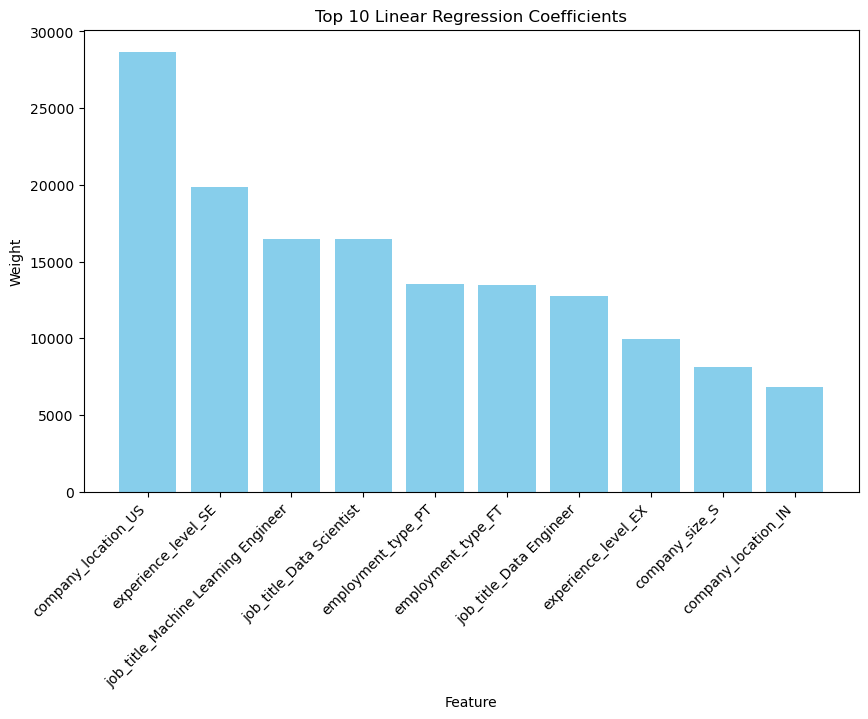

In [24]:
top_10_weights = weights_df.sort_values(by='Absolute_Weight', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_weights['Feature'], top_10_weights['Absolute_Weight'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title('Top 10 Linear Regression Coefficients')
plt.xticks(rotation=45, ha='right')
plt.show()

Итог по модели: на предсказание больше всего повлияли - *employment_type*, *experience_level*, *company_location*, *job_title*

### 3.4 Построение модели CatBoostRegressor

In [25]:
pipe_cat = Pipeline([
    ('Scaler', StandardScaler()),
    ('ragdoll', CatBoostRegressor(verbose = False))
])

param_grid_cat = {
    'ragdoll__learning_rate': [0.1, 0.2],
    'ragdoll__depth': [3, 5],
    'ragdoll__iterations': [100, 500],
}

grid_search_cat = GridSearchCV(pipe_cat, param_grid_cat, cv=5, scoring='r2', n_jobs=-1)

grid_search_cat.fit(X_train, y_train)

best_model_cat = grid_search_cat.best_estimator_


In [26]:
predictions_cat = best_model_cat.predict(X_test)

neg_mean_absolute_error_Cat = mean_absolute_error(y_test, predictions_cat)
neg_mean_squared_error_Cat = mean_squared_error(y_test, predictions_cat)
r2_Cat = r2_score(y_test, predictions_cat)

print(f'neg_mean_absolute_error: {round(neg_mean_absolute_error_Cat,2)}')
print(f'neg_mean_squared_error: {round(neg_mean_squared_error_Cat,2)}')
print(f'r2: {round(r2_Cat,2)}')

best_params = grid_search_cat.best_params_

print("Лучшие параметры:", best_params)

neg_mean_absolute_error: 26536.65
neg_mean_squared_error: 1177244383.83
r2: 0.53
Лучшие параметры: {'ragdoll__depth': 3, 'ragdoll__iterations': 100, 'ragdoll__learning_rate': 0.2}


In [27]:
importances = best_model_cat.named_steps['ragdoll'].feature_importances_
feature_names = X_train.columns  

feature_importance_dict = dict(zip(feature_names, importances))

top_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:10]
for feature, importance in top_features:
    print(f"{feature}: {importance}")


company_location_US: 52.280865637050894
experience_level_SE: 13.543273689751157
job_title_Data Scientist: 5.440233232856008
company_size_S: 4.7789832016618154
job_title_Machine Learning Engineer: 4.5090865365517665
job_title_Data Engineer: 3.4987899887111586
experience_level_MI: 2.8777232239276955
remote_ratio: 2.578516642494841
company_size_M: 2.3631443933305474
experience_level_EX: 2.0172806712487286


### 3.5 График, показывающий топ 10 фичей, наиболее влияющих на построение модели CatBoostRegressor

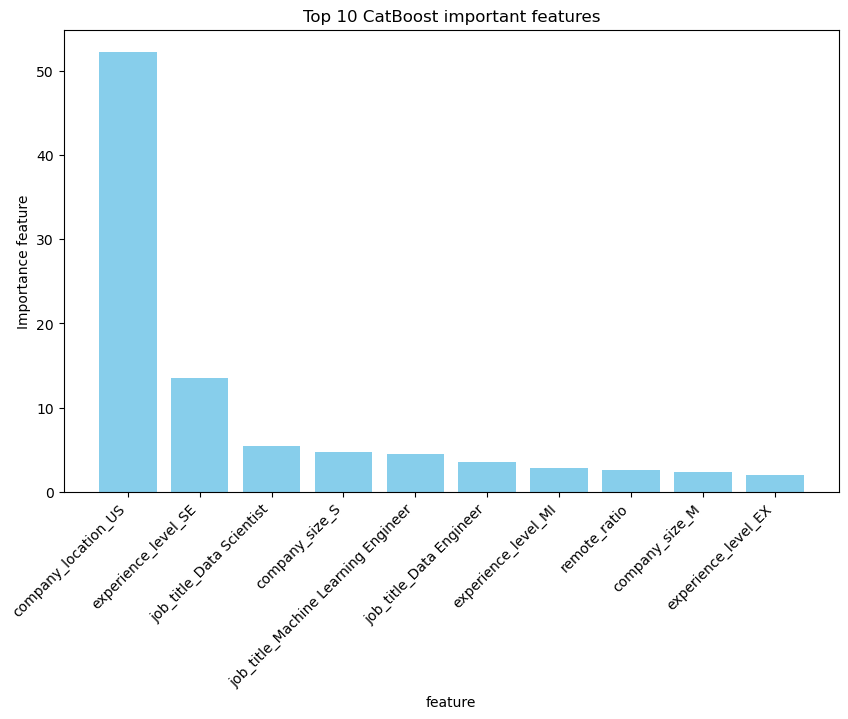

In [28]:
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

top_features = sorted_features[:10]
top_feature_names, top_feature_importances = zip(*top_features)

plt.figure(figsize=(10, 6))
plt.bar(top_feature_names, top_feature_importances, color='skyblue')
plt.xlabel('feature')
plt.ylabel('Importance feature')
plt.title('Top 10 CatBoost important features')
plt.xticks(rotation=45, ha='right')
plt.show()

Итог по модели: на предсказание больше всего повлияли - *company_location*, *experience_level*, *job_title*, *company_size*, *remote_ratio*

### 3.6 Построение модели MLPRegressor 

In [29]:
pipe_mlp = Pipeline([
    ('Scaler', StandardScaler()),
    ('mlp', MLPRegressor(verbose=False))
])

param_grid_mlp = {
    'mlp__activation': ['tanh'],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__solver': ['lbfgs', 'sgd']
}

grid_search_mlp = GridSearchCV(pipe_mlp, param_grid_mlp, cv=5, scoring='r2', n_jobs=-1,verbose=0)

grid_search_mlp.fit(X_train, y_train)

best_model_mlp = grid_search_mlp.best_estimator_

/Users/staspalatov/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/staspalatov/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/staspalatov/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/staspalatov/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter)

In [30]:
predictions_mlp = best_model_mlp.predict(X_test)

neg_mean_absolute_error_MLP = mean_absolute_error(y_test, predictions_mlp)
neg_mean_squared_error_MLP = mean_squared_error(y_test, predictions_mlp)
r2_MLP = r2_score(y_test, predictions_mlp)

print(f'neg_mean_absolute_error: {round(neg_mean_absolute_error_MLP,2)}')
print(f'neg_mean_squared_error: {round(neg_mean_squared_error_MLP,2)}')
print(f'r2: {round(r2_MLP,2)}')

best_params = grid_search_mlp.best_params_

print("Лучшие параметры:", best_params)

neg_mean_absolute_error: 28745.93
neg_mean_squared_error: 1528752775.65
r2: 0.39
Лучшие параметры: {'mlp__activation': 'tanh', 'mlp__learning_rate': 'constant', 'mlp__solver': 'sgd'}


In [31]:
importances_mlp = best_model_mlp.named_steps['mlp'].coefs_[0].mean(axis=0)

feature_importance_dict_mlp = dict(zip(X_train.columns, importances_mlp))

sorted_features_mlp = sorted(feature_importance_dict_mlp.items(), key=lambda x: x[1], reverse=True)

top_features_mlp = sorted_features_mlp[:10]

print("\nТоп 10 признаков и их важность:")
for feature, importance in top_features_mlp:
    print(f"{feature}: {importance}")


Топ 10 признаков и их важность:
company_location_IR: 1270.6825104095694
company_location_IT: 465.2306681235354
employment_type_FT: 360.0391825802195
company_location_PK: 298.8969326456164
company_location_MX: 254.420247762082
company_location_HR: 239.88937359087728
job_title_Data Engineer: 218.96873827667758
company_location_SI: 164.6023946706789
company_location_AU: 135.04250798079607
company_location_BE: 113.55867430867673


### 3.7 График, показывающий топ 10 фичей, наиболее влияющий на построение модели MLPRegressor

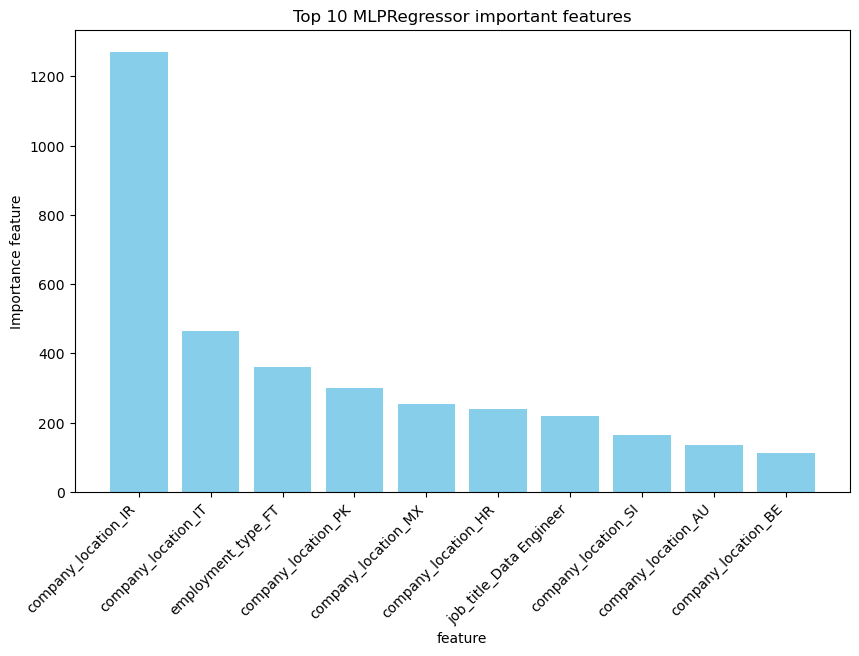

In [32]:
top_feature_names_mlp, top_feature_importances_mlp = zip(*top_features_mlp)

plt.figure(figsize=(10, 6))
plt.bar(top_feature_names_mlp, top_feature_importances_mlp, color='skyblue')
plt.xlabel('feature')
plt.ylabel('Importance feature')
plt.title('Top 10 MLPRegressor important features')
plt.xticks(rotation=45, ha='right')
plt.show()

Итог по модели: на предсказание больше всего повлияли: *company_location*, *experience_level*, *job_title*

In [33]:
columns = ['model', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

data = [
    ['LR', neg_mean_absolute_error_LR, neg_mean_squared_error_LR, r2_LR],
    ['CatBoostRegressor', neg_mean_absolute_error_Cat, neg_mean_squared_error_Cat, r2_Cat], 
    ['MLP', neg_mean_absolute_error_MLP, neg_mean_squared_error_MLP, r2_MLP]
]

df = pd.DataFrame(data, columns=columns)


In [34]:
df

,model,neg_mean_absolute_error,neg_mean_squared_error,r2
0,LR,27396.478026,1.327104e+09,0.470068
1,CatBoostRegressor,26536.651672,1.177244e+09,0.529909
2,MLP,28745.929271,1.528753e+09,0.389547


### 3.8 График, показывающий сравнение моделей по метрикам: *neg_mean_absolute_error*, *neg_mean_squared_error*, *r2*

In [35]:
models = df['model']
mae = df['neg_mean_absolute_error']
mse = df['neg_mean_squared_error']
r2 = df['r2']

fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=['MAE', 'MSE', 'R2'])

fig.add_trace(go.Bar(x=models, y=mae, name='MAE'), row=1, col=1)
fig.add_trace(go.Bar(x=models, y=mse, name='MSE'), row=2, col=1)
fig.add_trace(go.Bar(x=models, y=r2, name='R2'), row=3, col=1)

fig.update_layout(
    barmode='group',
    title_text='Comparison of metrics for different models',
    showlegend=False 
)

fig.show()


Итог по сравнению: лучше всего показала себя модель CatBoostRegressor 

### 4. **Итог**

По результатам анализа, можно сказать следующее : за период 3 года самымими популярными профессиями являются *Machine Learning Engineer* , *Data Analyst*, *Data Scientist*, *Data Engineer*. Зарплаты данных профессий ростут, главные страны-работодатели - это США, Великобритания, Германия, Индия, Канада и т.д. 
По результатам обучения модели для предсказания з/п этих профессий было выявлено следующее:
важными фичами являются *расположение компании*, *уровень опыта*, *размер компании* и *'удалённое соотношение'*
